In [1]:
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.calibration import calibration_curve

In [2]:
params = {'boosting_type': ('gbdt',), 
          'colsample_bytree': 0.6715464422148085, 
          'is_unbalance': False, 
          'learning_rate': 0.08708574904573461, 
          'max_depth': 5, 'min_child_samples': 180, 
          'num_leaves': 9, 
          'objective': ('binary',), 
          'reg_alpha': 0.9395374749727163, 
          'reg_lambda': 0.5002221421199993, 
          'subsample': 0.5009843440844668, 
          'subsample_for_bin': 20000,
          'metric':'auc'}

In [3]:
for n in range(1,6,1):
    X_train = np.load(f'../input/f{n}-final/Fold{n}_train_data_stats.npy')
    y_train = np.load(f'../input/f{n}-final/Fold{n}_train_label.npy')
    X_val = np.load(f'../input/f{n}-final/Fold{n}_val_data_stats.npy')
    y_val = np.load(f'../input/f{n}-final/Fold{n}_val_label.npy')
    
    d_train = lgb.Dataset(X_train, label= y_train)
    d_val = lgb.Dataset(X_val, label=y_val)
    
    gbm = lgb.train(params,
                    d_train,
                    num_boost_round=1500,
                    valid_sets=d_val,
                    early_stopping_rounds=10,
                    verbose_eval=100)
    
    gbm = gbm.save_model(f'lgb_fold{n}.txt', num_iteration=gbm.best_iteration)
    
    y_train_pred = gbm.predict(X_train)
    y_val_pred = gbm.predict(X_val)
    
    y_train_roc = roc_auc_score(y_train, y_train_pred)
    y_val_roc = roc_auc_score(y_val, y_val_pred)
    
    print(f'Fold {n} Train ROCAUC Score : {y_train_roc:.4f}')
    print(f'Fold {n} Val ROCAUC Score   : {y_val_roc:.4f}')

    if n == 1:
        y_oof = gbm.predict(X_val)
        y_oof = y_oof.reshape((y_oof.shape[0],1))
    else:
        y_pred = gbm.predict(X_val)
        y_pred = y_pred.reshape((y_pred.shape[0],1))
        y_oof = np.row_stack([y_oof, y_pred])

Training until validation scores don't improve for 10 rounds.
[100]	valid_0's auc: 0.729941
Early stopping, best iteration is:
[92]	valid_0's auc: 0.730685
Fold 1 Train ROCAUC Score : 0.7791
Fold 1 Val ROCAUC Score   : 0.7307
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[64]	valid_0's auc: 0.728173
Fold 2 Train ROCAUC Score : 0.7677
Fold 2 Val ROCAUC Score   : 0.7282
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's auc: 0.739298
Early stopping, best iteration is:
[109]	valid_0's auc: 0.740099
Fold 3 Train ROCAUC Score : 0.7853
Fold 3 Val ROCAUC Score   : 0.7401
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's auc: 0.722773
Early stopping, best iteration is:
[116]	valid_0's auc: 0.724502
Fold 4 Train ROCAUC Score : 0.7911
Fold 4 Val ROCAUC Score   : 0.7245
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[76]	valid_0's auc: 0.72798

In [4]:
for n in range(1,6,1):
    if n == 1:
        y_true = np.load(f'../input/f{n}-final/Fold{n}_val_label.npy')
        y_true = y_true.reshape((y_true.shape[0],1))
    else:
        y_fold = np.load(f'../input/f{n}-final/Fold{n}_val_label.npy')
        y_true = np.row_stack([y_true, y_fold.reshape((y_fold.shape[0], 1))])

In [5]:
oof_rocauc = roc_auc_score(y_true, y_oof)
print(f'OOF ROCAUC Score : {oof_rocauc:.4f}')

OOF ROCAUC Score : 0.7300


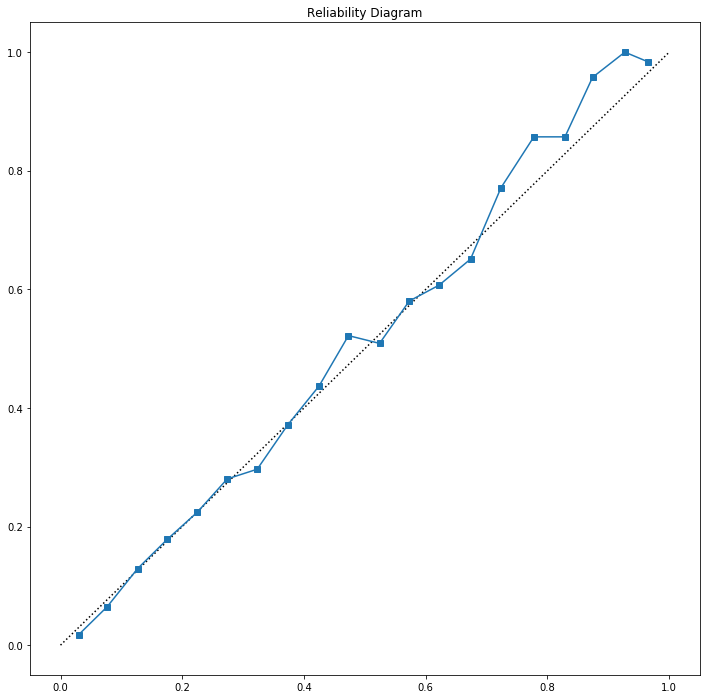

In [6]:
fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_oof, n_bins =20)

plt.figure(figsize=(12,12))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=f'Out of fold Prediction')
plt.title(f'Reliability Diagram')
plt.show()

In [7]:
np.save('LGBM_oof_predictions.npy', y_oof)